In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.transforms import (
    MonotonicAffineTransform,
)
from zuko.flows import UnconditionalDistribution
from torch.distributions import Cauchy, Normal, Laplace, Bernoulli, Uniform
import copy
from causal_cocycle.model_new import ZukoCocycleModel
from causal_cocycle.optimise_new import optimise
from causal_cocycle.loss import CocycleLoss
from causal_cocycle.loss_factory import CocycleLossFactory
from causal_cocycle.kernels import gaussian_kernel
from scipy.stats import betaprime, norm
import numpy as np
from architectures import get_nsf_transforms, IdentityTransform,DiscreteSelectorTransform

In [2]:
# ── Data ─────────────────────────────────────────────────────
N_train = 100 # Since only four possible points, can set N arbitrarily to a 4K and draw K of each point. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
U = torch.cat([torch.ones(N_train //2),torch.zeros(N_train // 2)])[:,None]
X = torch.cat([torch.ones(N_train // 4),torch.zeros(N_train // 4),torch.ones(N_train // 4),torch.zeros(N_train // 4)])[:,None]
Y = (X+1)*U

In [3]:
# ── Build loss and transforms ───────────────────────────────
d = 1   # dim(Y)

nsf = get_nsf_transforms()[0][0]

flow0 = IdentityTransform()
discrete_nsf_selector_transform = DiscreteSelectorTransform(nn.ModuleList([IdentityTransform(), nsf]))
model = ZukoCocycleModel(transforms=torch.nn.ModuleList([discrete_nsf_selector_transform]))

kernel = [gaussian_kernel(), gaussian_kernel()]
loss_factory = CocycleLossFactory(kernel)
loss = loss_factory.build_loss("CMMD_V", X, Y)

In [4]:
# Example hyperparameters—feel free to adjust as desired:
learn_rate       = 1e-2
epochs           = 1000
batch_size       = 128

# Finally, run training. We supply both train and val sets so optimise can compute validation loss each epoch:
best_model, history = optimise(
    model            = model,
    loss_tr          = loss,
    inputs           = X,
    outputs          = Y,
    inputs_val       = None,
    outputs_val      = None,
    learn_rate       = learn_rate,
    epochs           = epochs,
    batch_size       = batch_size,
)

Epoch 1/1000, Training Loss: -0.3686
Epoch 2/1000, Training Loss: -0.3692
Epoch 3/1000, Training Loss: -0.3698
Epoch 4/1000, Training Loss: -0.3705
Epoch 5/1000, Training Loss: -0.3711
Epoch 6/1000, Training Loss: -0.3717
Epoch 7/1000, Training Loss: -0.3724
Epoch 8/1000, Training Loss: -0.3730
Epoch 9/1000, Training Loss: -0.3736
Epoch 10/1000, Training Loss: -0.3742
Epoch 11/1000, Training Loss: -0.3748
Epoch 12/1000, Training Loss: -0.3754
Epoch 13/1000, Training Loss: -0.3759
Epoch 14/1000, Training Loss: -0.3765
Epoch 15/1000, Training Loss: -0.3771
Epoch 16/1000, Training Loss: -0.3777
Epoch 17/1000, Training Loss: -0.3782
Epoch 18/1000, Training Loss: -0.3788
Epoch 19/1000, Training Loss: -0.3793
Epoch 20/1000, Training Loss: -0.3799
Epoch 21/1000, Training Loss: -0.3804
Epoch 22/1000, Training Loss: -0.3809
Epoch 23/1000, Training Loss: -0.3814
Epoch 24/1000, Training Loss: -0.3820
Epoch 25/1000, Training Loss: -0.3825
Epoch 26/1000, Training Loss: -0.3830
Epoch 27/1000, Traini

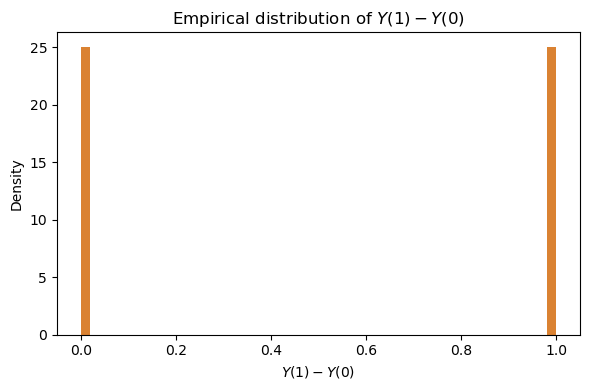

In [5]:
# ── 4) Paired sampling via reseeding ──────────────────────────────────────────
N_effect = 10**5
Y0_eff,X0_eff = Y[X==0][:,None], X[X==0][:,None]
with torch.no_grad():
    Y1_eff = model.cocycle(X0_eff+1,X0_eff,Y0_eff)
delta = (Y1_eff - Y0_eff).squeeze(-1)
Y0 = Bernoulli(1/2).sample((N_effect,)).to(device)
Y1 = Y0*2
true_delta = Y1-Y0

# ── 5) Plot empirical histogram of ΔY ────────────────────────────────────────
plt.figure(figsize=(6,4))
plt.hist((true_delta), bins=50, density=True, alpha=0.8)
plt.hist((delta), bins=50, density=True, alpha=0.8)
plt.title("Empirical distribution of $Y(1)-Y(0)$")
plt.xlabel("$Y(1)-Y(0)$")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

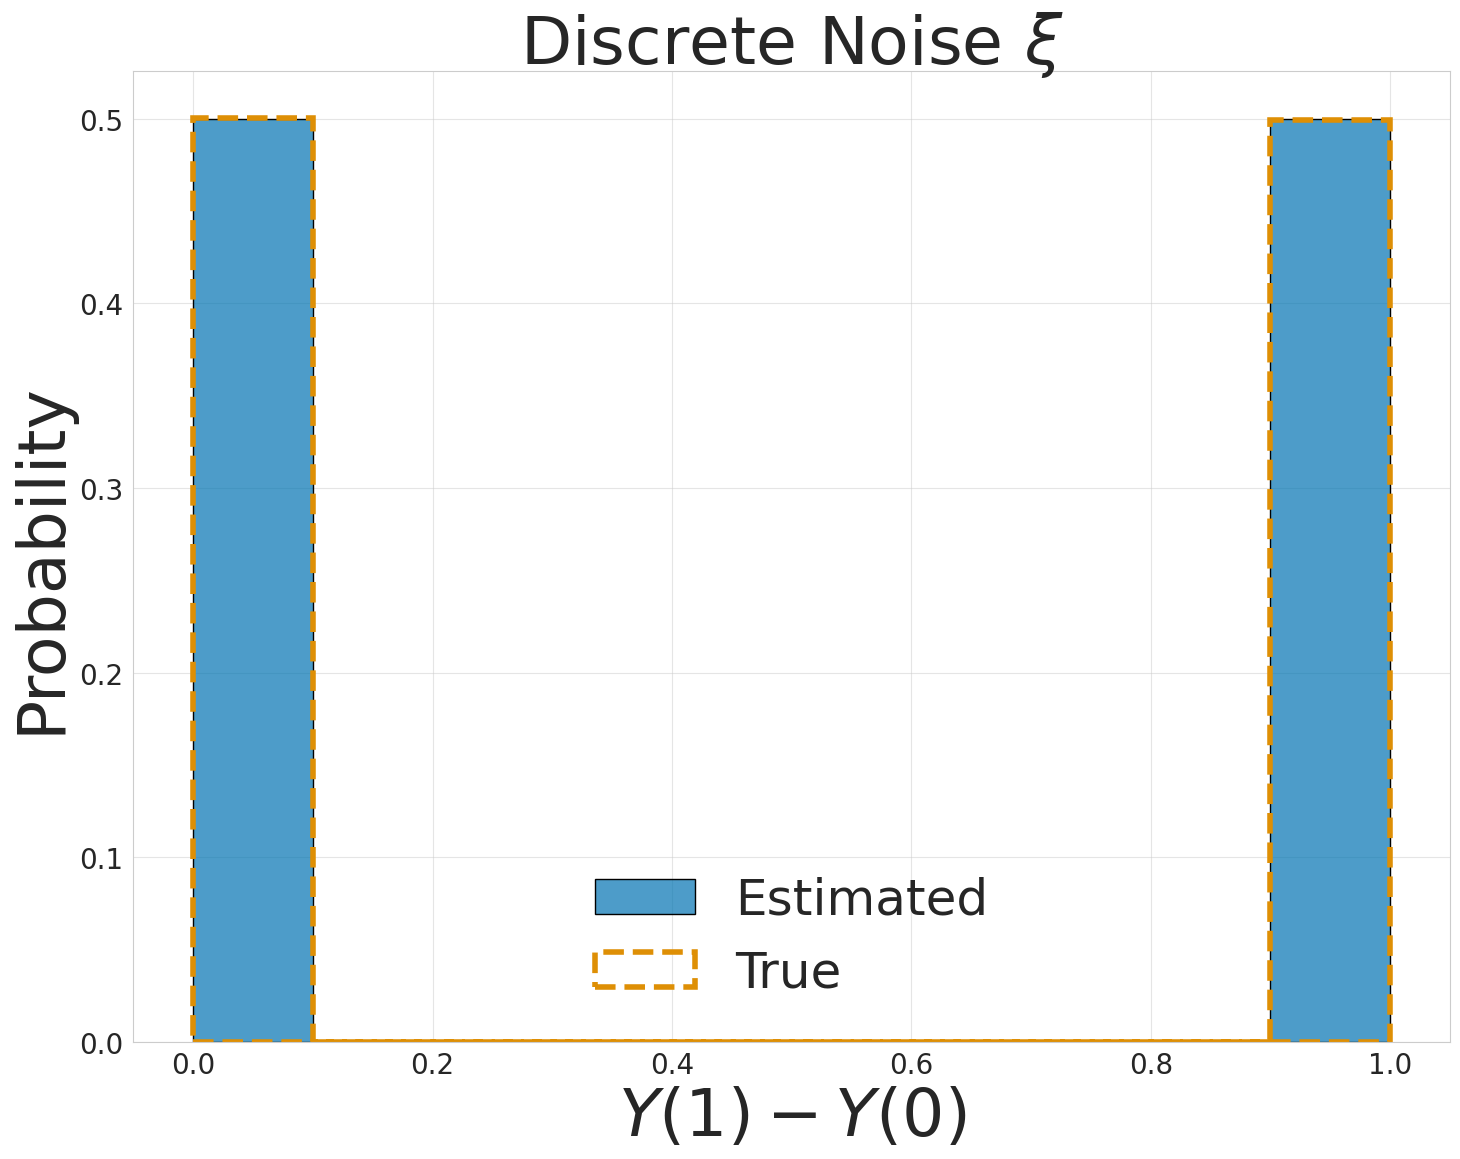

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
})
sns.set_style("whitegrid")
col_data, col_true = sns.color_palette("colorblind", 2)

# Adjust bins as needed for your support

fig, ax = plt.subplots(figsize=(15, 12))

# Estimated/model histogram
sns.histplot(
    delta, bins=10, stat="probability", alpha=0.7, color=col_data, 
    label="Estimated", ax=ax, edgecolor="black"
)

# True histogram (outline only)
sns.histplot(
    true_delta, bins=10, stat="probability", alpha=0, color=col_true, 
    label="True", ax=ax, edgecolor=col_true, linewidth=4, ls = "dashed",
)

ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=48)
ax.set_ylabel("Probability", fontsize=48)
ax.set_title(r"Discrete Noise $\xi$", fontsize=48)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=36)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cocycle_misspec_discrete.png", bbox_inches="tight")
plt.show()

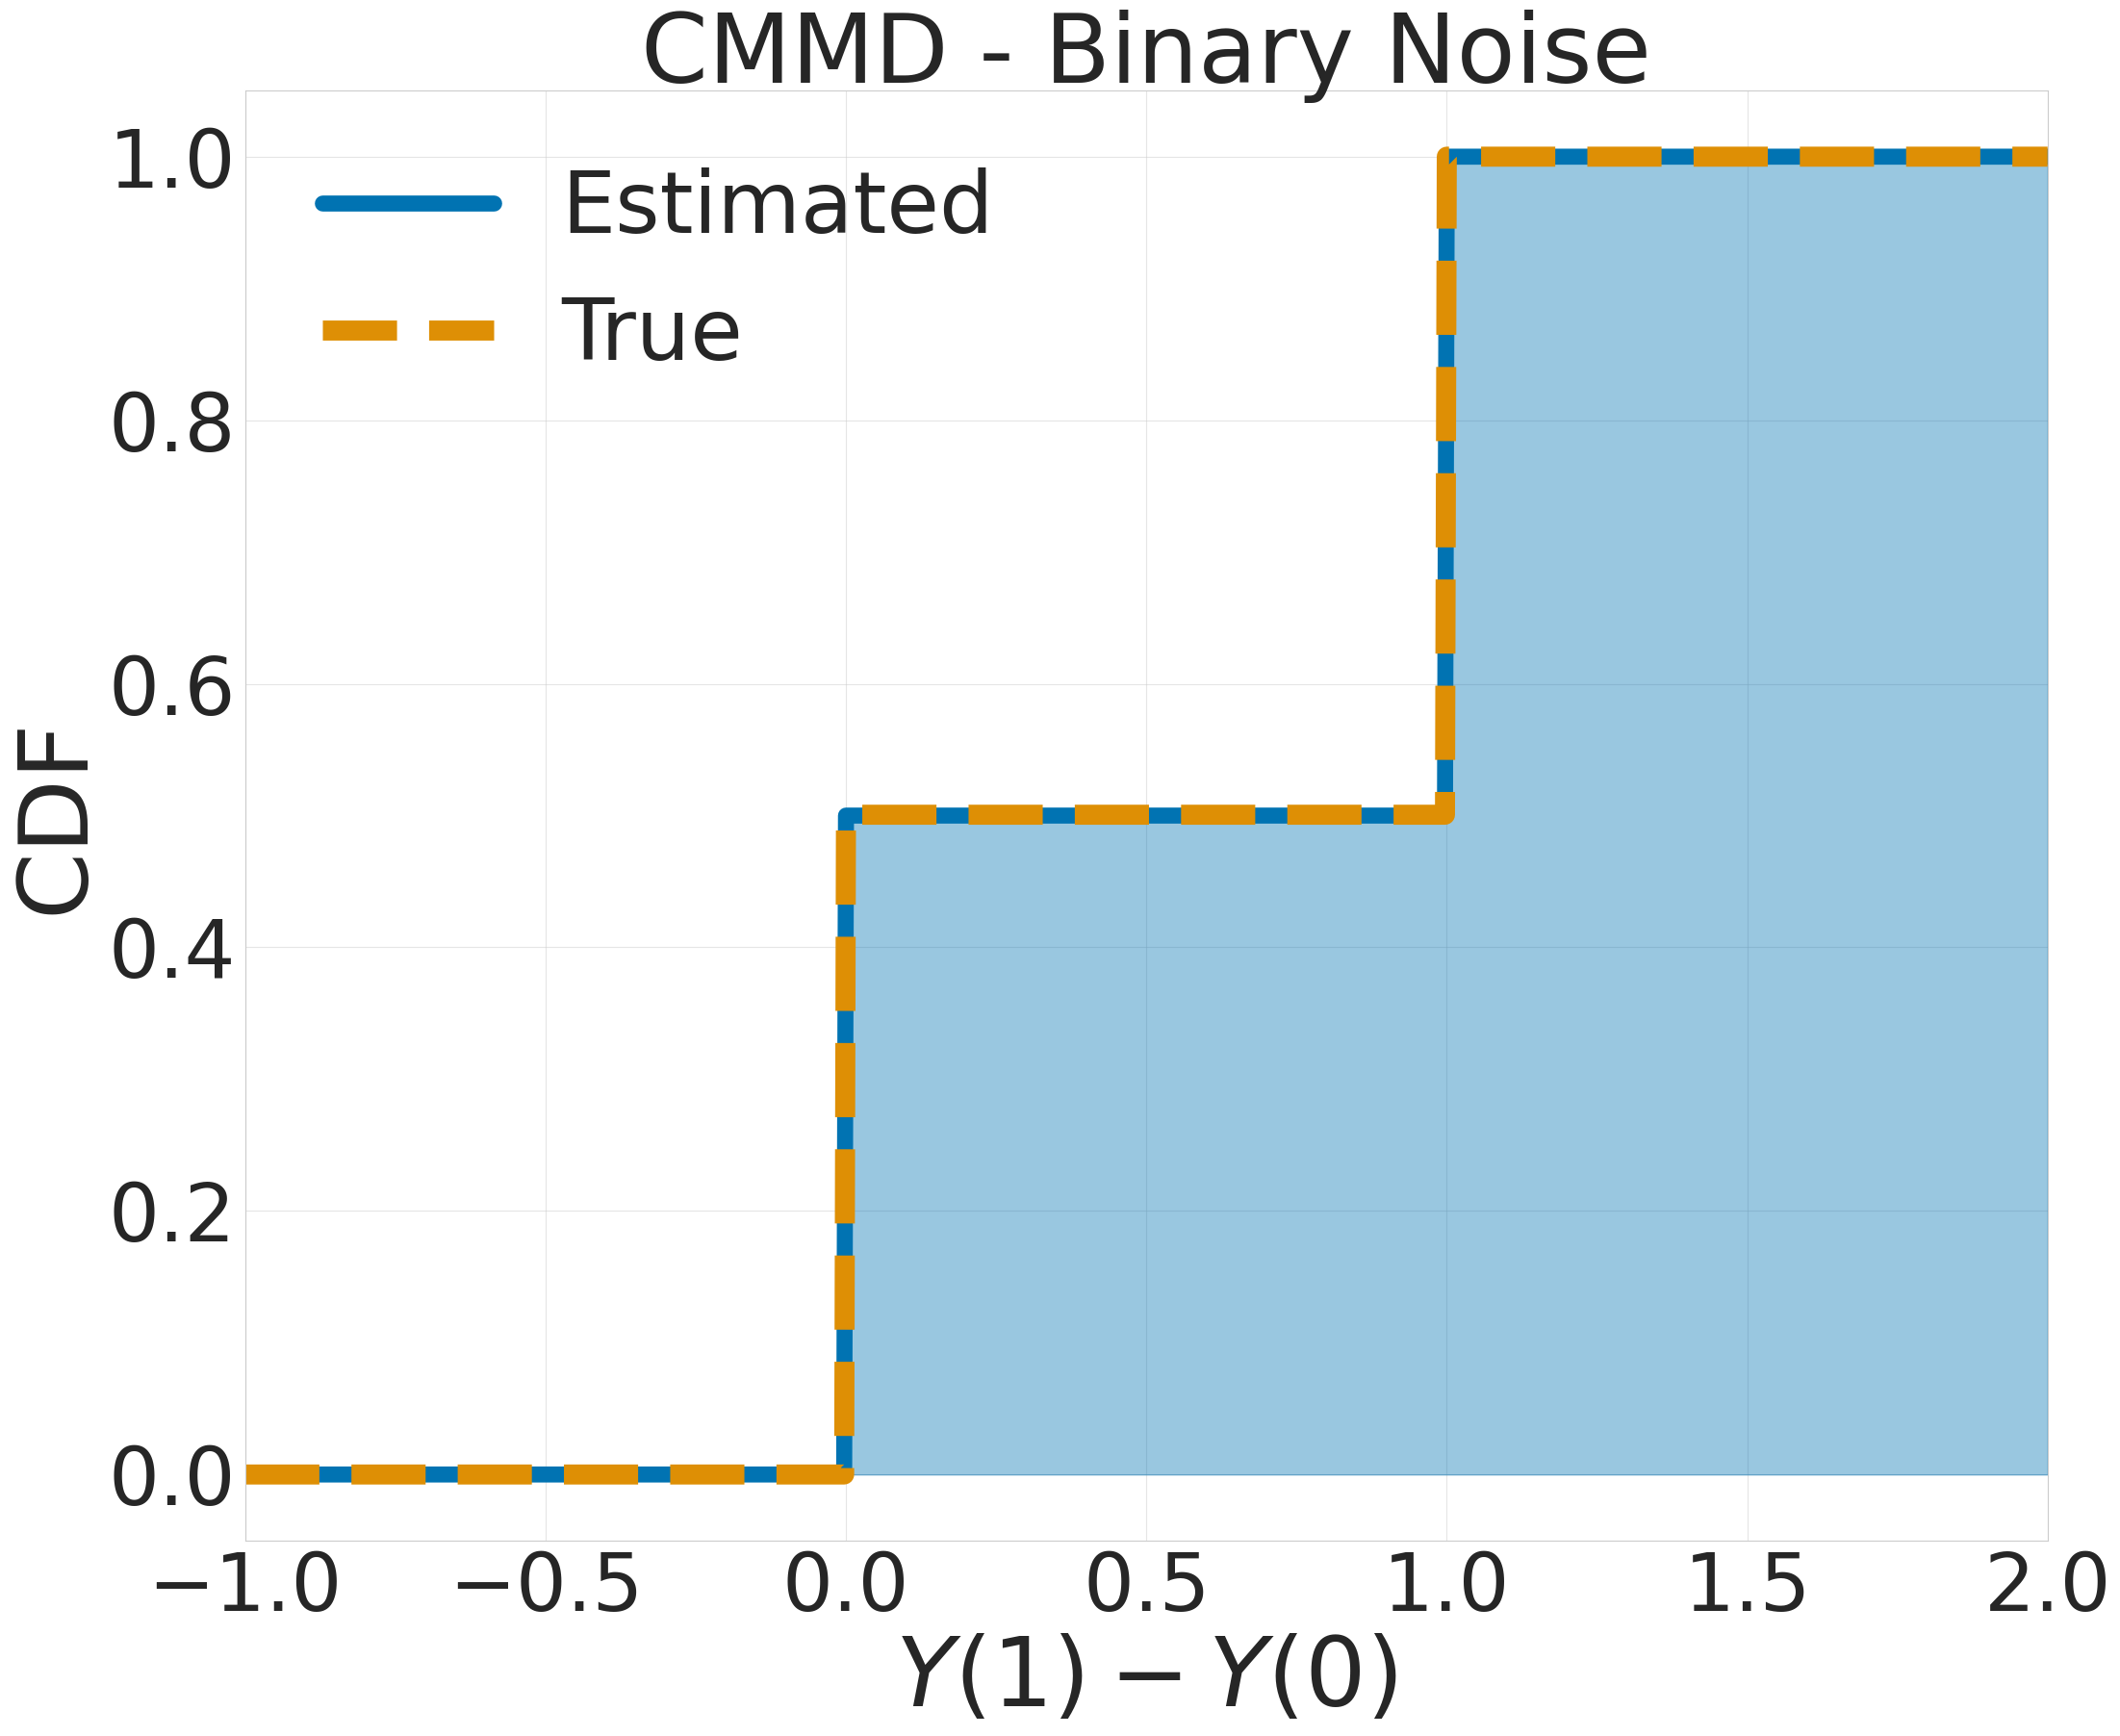

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

plt.rcParams.update({
    'font.size': 72,
    'axes.titlesize': 72,
    'axes.labelsize': 72,
    'xtick.labelsize': 48,
    'ytick.labelsize': 48
})
sns.set_style("whitegrid")

# Define fixed x-grid
x_grid = np.linspace(-1, 2, 1000)

# Sort inputs
delta_sorted = np.sort(delta)
true_delta_sorted = np.sort(true_delta)

# Compute empirical CDFs on fixed grid
cdf_delta = np.searchsorted(delta_sorted, x_grid, side="right") / len(delta_sorted)
cdf_true = np.searchsorted(true_delta_sorted, x_grid, side="right") / len(true_delta_sorted)

# Colors
col_data, col_true = sns.color_palette("colorblind", 2)

# Plot
fig, ax = plt.subplots(figsize=(24, 20))  # ⬅️ Doubled size

ax.plot(x_grid, cdf_delta, color=col_data, lw=12, label="Estimated")
ax.fill_between(x_grid, 0, cdf_delta, color=col_data, alpha=0.4)
ax.plot(x_grid, cdf_true, color=col_true, lw=15, ls="--", label="True")

# Labels with doubled fontsize
ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=72)
ax.set_ylabel("CDF", fontsize=72)
ax.set_title(r"CMMD - Binary Noise", fontsize=72)

# Tick label size adjustment
ax.tick_params(axis='x', labelsize=60)  # ⬅️ Much larger x-tick labels
ax.tick_params(axis='y', labelsize=60)

# Formatting
ax.set_xlim([-1, 2])
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.legend(frameon=False, fontsize=64)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("cocycles_misspec_discrete_large.png", bbox_inches="tight")
plt.show()
